### Generate some statistics files

In [1]:
! pip install libsumo addict

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import analysis.stats_utils as stats_utils
from analysis.viz_utils import visualizer
import os
from tqdm import tqdm
# change here
exp_repo = "/gpfs/accounts/henryliu_root/henryliu98/shared_data/safetest-nade/"
mode="ITE_autoware_universe_map_recalibrate_v4"
user = "haowei"
experiment_record_repo = f"{exp_repo}/{mode}/raw_data"
export_stat_dir = f"{exp_repo}/{mode}/{user}/processed_data"

# # test code
# experiment_record_repo = "output/test/raw_data"
# export_stat_dir = "output/test/processed_data"
# export_stat_dir = "."

if not os.path.exists(export_stat_dir):
    os.system(f"mkdir -p {export_stat_dir}")
    os.system(f"chmod 755 {export_stat_dir}")

In [2]:
stats_utils.export_to_csv(experiment_record_repo, export_stat_dir)
os.system(f"chmod -R 775 {export_stat_dir}")

100%|██████████| 20567/20567 [01:17<00:00, 265.86it/s]

info_error:  0


0

In [3]:
awk_cmd = """awk -F "[_/]" '{print $35}'""" + " check.txt | sort | uniq -cd"
print("count", "exp_id")
os.system(awk_cmd)

count exp_id


0

### Analyze

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

#### Import statistics of each experiment

In [5]:
exp_stats_info = pd.read_csv(f"{export_stat_dir}/stats.tsv", sep='\t')
exp_stats_info.head()

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
0,ITE_autoware_universe_map_recalibrate_v4_118_1,1257.0,957,300,NaN,NaN,-0.074820,666,NaN,-1.0,NaN,NaN,53816.192710,1047.978212,NaN,NaN,NaN,None,-10.000000,NaN
1,ITE_autoware_universe_map_recalibrate_v4_118_2,1397.0,1097,300,NaN,NaN,-0.116591,699,NaN,-1.0,NaN,NaN,57202.698658,843.248076,NaN,NaN,NaN,None,-10.000000,NaN
2,ITE_autoware_universe_map_recalibrate_v4_118_3,1310.6,1179,300,BV_2.31,BV_7.11,2.777301,710,BV_2.31,0.6,LeftFoll,intersection_cutin,31190.661110,140.829624,EG_8_23_12_1,angle,intersection,20.583022226154412,-1.116604,0.960536
3,ITE_autoware_universe_map_recalibrate_v4_118_4,1466.0,1166,300,NaN,NaN,2.176504,709,NaN,-1.0,NaN,NaN,51465.757701,1559.678246,NaN,NaN,NaN,None,-10.000000,NaN
4,ITE_autoware_universe_map_recalibrate_v4_118_5,1341.0,1041,300,NaN,NaN,-0.174743,1065,NaN,-1.0,NaN,NaN,60747.694151,3946.686037,NaN,NaN,NaN,None,-10.000000,NaN


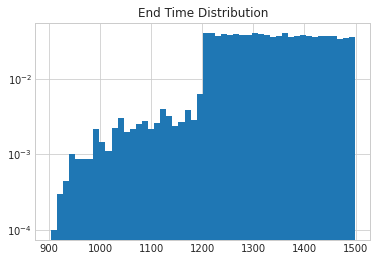

In [6]:
num_experiments = len(exp_stats_info)
plt.hist(exp_stats_info["end_time"], weights=np.ones(num_experiments)/num_experiments, bins=50)
plt.yscale("log")
plt.title("End Time Distribution")
plt.savefig(f"{export_stat_dir}/end_time.png")

**Filter the experiments with time difference between negligence and collision larger than 3s**

In [8]:
warm_up_time = exp_stats_info["warmup_time"]
estimated_end_time = exp_stats_info["warmup_time"] + exp_stats_info["run_time"]

has_collision = (exp_stats_info['end_time'] < estimated_end_time) & (exp_stats_info['end_time'] >= warm_up_time)
collision_df = exp_stats_info[has_collision]

has_collision_in_warmup = (exp_stats_info['end_time'] <= warm_up_time)
warmup_collision_df = exp_stats_info[has_collision_in_warmup]

print("Collision numbers:", len(collision_df), "Warmup collisions:", len(warmup_collision_df)) # the number of collisions 

Collision numbers: 2047 Warmup collisions: 0


**See the list of files with time difference between negligence and collision larger than 3s**

### See the collisions

In [9]:
collision_df.head()

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
2,ITE_autoware_universe_map_recalibrate_v4_118_3,1310.6,1179,300,BV_2.31,BV_7.11,2.777301,710,BV_2.31,0.6,LeftFoll,intersection_cutin,31190.661110,140.829624,EG_8_23_12_1,angle,intersection,20.583022226154412,-1.116604,0.960536
11,ITE_autoware_universe_map_recalibrate_v4_118_12,1040.2,967,300,BV_14.4,BV_9.15,3.253758,390,BV_9.15,2.7,Lead,roundabout_neglect_conflict_lead,16831.219441,576.257877,:NODE_14_1_0,angle,roundabout,97.83611056896758,3.280000,4.586767
17,ITE_autoware_universe_map_recalibrate_v4_118_18,1167.8,974,300,BV_8.76,BV_8.77,1.786669,1611,BV_8.77,2.4,Lead,highway_rearend,25805.490621,820.902767,EG_1_3_1_0,rear_end,freeway_1,2.842170943040401e-14,-0.729957,7.588664
18,ITE_autoware_universe_map_recalibrate_v4_118_19,1057.8,1031,300,BV_21.42,BV_8.57,3.286579,228,BV_21.42,0.6,RightFoll,highway_cutin,5503.213472,504.698526,EG_1_3_1_0,sideswipe,freeway_1,18.958886953372073,-0.705334,2.193285
39,ITE_autoware_universe_map_recalibrate_v4_118_40,1082.5,1023,300,BV_17.53,BV_21.48,3.297926,38,BV_17.53,0.6,LeftFoll,highway_cutin,10816.009462,368.438326,EG_1_3_1_1,sideswipe,freeway_1,18.319265687326947,-1.030658,2.543785


In [10]:
all_maneuvers = exp_stats_info["maneuver_challenge"].sum()
all_time = (exp_stats_info["end_time"] - exp_stats_info["warmup_time"]).sum()
all_routes = exp_stats_info["route_length"].sum()
mile_to_m = 1609.344
no_negligence_collision_related = collision_df['neg_time_diff'] < 0
power_importance_weight = np.power(10, - exp_stats_info['importance'])
collide_importance_weight = power_importance_weight[(power_importance_weight < 1) & has_collision]
importance_all = collide_importance_weight.sum()
num_experiments = len(exp_stats_info)
num_collisions = len(collision_df)
no_related_negligence_collision = collision_df[no_negligence_collision_related]

print(f"Number of experiments: {num_experiments}")
print(f"Number of collision: {num_collisions}")
print(f"Collisions with weight less than 1: {len(collide_importance_weight)}")
print(f"Importance summation: {importance_all}")
print(f"Max weight: {collide_importance_weight.max()}, Min weight: {collide_importance_weight.min()}")
print(f"raw collision rate: {num_collisions / num_experiments}")
print(f"adjusted collision rate (importance): {importance_all/num_experiments}")
print(f"Collision due to traffic light ignorance: {len(collision_df[collision_df['neg_reason'] == 'TFL'])}")
print(f"Overall maneuvers: {all_maneuvers}")

print(f"Collision without negligence: {len(no_related_negligence_collision)}")
print(f"Maximum time between collision and negligence: {collision_df['neg_time_diff'].max():.2f} s")

print()
print(f"Overall time: {all_time:.2f} s")
print(f"Maneuvers per second: {all_maneuvers / all_time}")
print(f"Overall route length: {all_routes:.2f} m")
print(f"m/s: {all_routes/all_time}")
print(f"Overall route length: {all_routes/mile_to_m} mile")
print(f"mile/s: {all_routes/mile_to_m/all_time} mile/s")
print(f"Crash per mile: {importance_all/all_routes*mile_to_m} crash/mile")

Number of experiments: 20567
Number of collision: 2047
Collisions with weight less than 1: 1915
Importance summation: 2.2750996802335335
Max weight: 0.03214867657825938, Min weight: 8.529309707331033e-14
raw collision rate: 0.09952837069091262
adjusted collision rate (importance): 0.00011061893714365408
Collision due to traffic light ignorance: 116
Overall maneuvers: 18191696
Collision without negligence: 145
Maximum time between collision and negligence: 4.20 s

Overall time: 5858049.70 s
Maneuvers per second: 3.105418514970946
Overall route length: 1162280319.05 m
m/s: 198.4073844658661
Overall route length: 722207.5075608769 mile
mile/s: 0.12328463303424632 mile/s
Crash per mile: 3.150202201465981e-06 crash/mile


In [11]:
exp_stats_info.head()

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
0,ITE_autoware_universe_map_recalibrate_v4_118_1,1257.0,957,300,NaN,NaN,-0.074820,666,NaN,-1.0,NaN,NaN,53816.192710,1047.978212,NaN,NaN,NaN,None,-10.000000,NaN
1,ITE_autoware_universe_map_recalibrate_v4_118_2,1397.0,1097,300,NaN,NaN,-0.116591,699,NaN,-1.0,NaN,NaN,57202.698658,843.248076,NaN,NaN,NaN,None,-10.000000,NaN
2,ITE_autoware_universe_map_recalibrate_v4_118_3,1310.6,1179,300,BV_2.31,BV_7.11,2.777301,710,BV_2.31,0.6,LeftFoll,intersection_cutin,31190.661110,140.829624,EG_8_23_12_1,angle,intersection,20.583022226154412,-1.116604,0.960536
3,ITE_autoware_universe_map_recalibrate_v4_118_4,1466.0,1166,300,NaN,NaN,2.176504,709,NaN,-1.0,NaN,NaN,51465.757701,1559.678246,NaN,NaN,NaN,None,-10.000000,NaN
4,ITE_autoware_universe_map_recalibrate_v4_118_5,1341.0,1041,300,NaN,NaN,-0.174743,1065,NaN,-1.0,NaN,NaN,60747.694151,3946.686037,NaN,NaN,NaN,None,-10.000000,NaN


In [12]:
a = exp_stats_info[(exp_stats_info["importance"] <= 0) & (exp_stats_info["end_time"] < exp_stats_info["warmup_time"] + exp_stats_info["run_time"])]
a

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
59,ITE_autoware_universe_map_recalibrate_v4_63_19,1298.2,1199,300,BV_5.15,BV_4.20,-0.025001,348,BV_4.20,-1.0,NaN,NaN,20803.736703,874.077000,:NODE_11_15_0,head_on,intersection,139.29335418128204,3.280000,6.561634
247,ITE_autoware_universe_map_recalibrate_v4_178_39,1280.3,998,300,BV_19.16,BV_19.17,-0.133627,699,BV_19.17,-1.0,NaN,NaN,57540.496828,5483.418602,EG_16_45_1_1,angle,roundabout_2,65.55587299291068,-1.818587,2.212455
391,ITE_autoware_universe_map_recalibrate_v4_391_32,1127.3,1062,300,BV_21.56,BV_8.56,-0.008878,151,BV_8.56,-1.0,NaN,NaN,14390.852783,723.388488,:nd_34_1_6_1_0,sideswipe,roundabout_1,18.589148938128233,3.280000,1.888904
516,ITE_autoware_universe_map_recalibrate_v4_296_32,1054.9,992,300,BV_8.50,BV_17.45,-0.007972,117,BV_17.45,-1.0,NaN,NaN,11047.602721,0.000000,:nd_34_1_6_0_0,angle,roundabout_1,26.04917738345023,-1.000000,3.243328
984,ITE_autoware_universe_map_recalibrate_v4_408_4,1379.4,1166,300,BV_2.38,BV_2.39,-0.118480,437,BV_2.39,-1.0,NaN,NaN,40652.481362,2428.968437,EG_18_12_171_1,angle,intersection,61.37169144070003,-0.319347,2.746099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19494,ITE_autoware_universe_map_recalibrate_v4_265_6,1224.4,996,300,BV_22.17,BV_21.48,-0.077134,1029,BV_21.48,-1.0,NaN,NaN,29573.936701,2729.661352,:nd_34_1_6_0_0,sideswipe,roundabout_1,16.722224723526722,3.280000,4.708551
19513,ITE_autoware_universe_map_recalibrate_v4_265_25,1169.4,1167,300,BV_16.13,BV_7.9,-0.002413,20,BV_7.9,-1.0,NaN,NaN,552.974549,72.527101,:NODE_18_10_0,head_on,intersection,122.69795971228234,3.280000,5.071937
19800,ITE_autoware_universe_map_recalibrate_v4_60_43,1048.7,902,300,BV_2.32,BV_2.33,-0.044793,524,BV_2.33,-1.0,NaN,NaN,26000.654466,647.418328,EG_18_12_171_1,angle,intersection,62.00727424542947,-0.349467,2.698711
19846,ITE_autoware_universe_map_recalibrate_v4_292_9,1178.8,1054,300,BV_2.41,BV_2.42,-0.038278,453,BV_2.42,-1.0,NaN,NaN,22602.969489,980.066291,EG_18_12_171_1,angle,intersection,62.19163863174845,-0.273570,2.741713


#### BV_22 Collision

In [13]:
is_veh_1_bv_22 = np.array(list(map(lambda x: x.startswith("BV_22"), collision_df["crash_veh_1"])))
is_veh_2_bv_22 = np.array(list(map(lambda x: x.startswith("BV_22"), collision_df["crash_veh_2"])))
has_bv_22 = is_veh_1_bv_22 | is_veh_2_bv_22
bv_22_collision_df = collision_df[has_bv_22]

total_bv_22_distance = exp_stats_info["bv_22_route_length"].sum()

num_bv_22_expr = np.sum(has_bv_22)
bv_22_collision_is_large_1 = bv_22_collision_df["importance"] < 0
power_bv_22_weight = np.power(10, -bv_22_collision_df["importance"])[~bv_22_collision_is_large_1]
bv_22_importance = np.sum(power_bv_22_weight)

print("Number of bv_22 collision:", num_bv_22_expr)
print("Total bv_22 distance:", total_bv_22_distance)
print("Number of bv_22 collision importance > 1:", np.sum(bv_22_collision_is_large_1))
print("Raw collision rate:", num_bv_22_expr / num_experiments)
print("Collision rate:", bv_22_importance / num_experiments)
print("Collision rate (weighted):", bv_22_importance / total_bv_22_distance * mile_to_m)

Number of bv_22 collision: 185
Total bv_22 distance: 59350177.374677904
Number of bv_22 collision importance > 1: 11
Raw collision rate: 0.008994991977439588
Collision rate: 9.972298383272016e-06
Collision rate (weighted): 5.561514536201013e-06


### Crash Distribution (with negligence)

In [14]:
exp_stats_info[(exp_stats_info["importance"] <= 0) & (exp_stats_info["end_time"] < 1200) & (exp_stats_info["neg_time_diff"]  > 0)]

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity


### Load file that show the relationship between lane and experiment

**See the collision number in each experiment**

In [15]:
exp_stats_info.head()

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
0,ITE_autoware_universe_map_recalibrate_v4_118_1,1257.0,957,300,NaN,NaN,-0.074820,666,NaN,-1.0,NaN,NaN,53816.192710,1047.978212,NaN,NaN,NaN,None,-10.000000,NaN
1,ITE_autoware_universe_map_recalibrate_v4_118_2,1397.0,1097,300,NaN,NaN,-0.116591,699,NaN,-1.0,NaN,NaN,57202.698658,843.248076,NaN,NaN,NaN,None,-10.000000,NaN
2,ITE_autoware_universe_map_recalibrate_v4_118_3,1310.6,1179,300,BV_2.31,BV_7.11,2.777301,710,BV_2.31,0.6,LeftFoll,intersection_cutin,31190.661110,140.829624,EG_8_23_12_1,angle,intersection,20.583022226154412,-1.116604,0.960536
3,ITE_autoware_universe_map_recalibrate_v4_118_4,1466.0,1166,300,NaN,NaN,2.176504,709,NaN,-1.0,NaN,NaN,51465.757701,1559.678246,NaN,NaN,NaN,None,-10.000000,NaN
4,ITE_autoware_universe_map_recalibrate_v4_118_5,1341.0,1041,300,NaN,NaN,-0.174743,1065,NaN,-1.0,NaN,NaN,60747.694151,3946.686037,NaN,NaN,NaN,None,-10.000000,NaN


In [16]:
# collision: negligence-caused 和 no negligence caused (SUMO)
# 每个种类做collision node的分布
neg_caused_collision = exp_stats_info[exp_stats_info["neg_time_diff"] >= 0 & has_collision] # weight < 1 collisions
no_neg_realated_collision = exp_stats_info[(exp_stats_info["neg_time_diff"] < 0) & has_collision]
print(len(neg_caused_collision), len(no_neg_realated_collision))

1902 145


Negligence caused distribution

In [17]:
neg_caused_collision["lane_id"].value_counts()

EG_25_2_1_0      221
EG_1_3_1_1       145
EG_16_23_1_1     125
EG_1_3_1_0       108
EG_17_1_1_0       76
                ... 
EG_9_1_1_0         1
:NODE_13_1_0       1
:nd_4_1_1_0_0      1
:nd_8_3_2_0_1      1
:NODE_14_2_0       1
Name: lane_id, Length: 102, dtype: int64

No negligence caused distribution

In [18]:
print(no_neg_realated_collision["lane_id"].value_counts())
print(len(no_neg_realated_collision))

:NODE_18_10_0     70
:nd_34_1_6_0_0    20
:NODE_11_15_0     12
:nd_34_1_6_1_0    11
EG_18_12_171_1     9
EG_16_45_1_1       5
:NODE_11_16_0      5
:NODE_18_17_0      4
EG_18_12_171_0     2
:NODE_18_8_0       2
gneE8_0            2
:NODE_24_5_0       1
EG_34_1_16_0       1
:NODE_18_1_0       1
Name: lane_id, dtype: int64
145


### Crash Distribution (with negligence)

In [19]:
neg_caused_collision.head()

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
2,ITE_autoware_universe_map_recalibrate_v4_118_3,1310.6,1179,300,BV_2.31,BV_7.11,2.777301,710,BV_2.31,0.6,LeftFoll,intersection_cutin,31190.661110,140.829624,EG_8_23_12_1,angle,intersection,20.583022226154412,-1.116604,0.960536
11,ITE_autoware_universe_map_recalibrate_v4_118_12,1040.2,967,300,BV_14.4,BV_9.15,3.253758,390,BV_9.15,2.7,Lead,roundabout_neglect_conflict_lead,16831.219441,576.257877,:NODE_14_1_0,angle,roundabout,97.83611056896758,3.280000,4.586767
17,ITE_autoware_universe_map_recalibrate_v4_118_18,1167.8,974,300,BV_8.76,BV_8.77,1.786669,1611,BV_8.77,2.4,Lead,highway_rearend,25805.490621,820.902767,EG_1_3_1_0,rear_end,freeway_1,2.842170943040401e-14,-0.729957,7.588664
18,ITE_autoware_universe_map_recalibrate_v4_118_19,1057.8,1031,300,BV_21.42,BV_8.57,3.286579,228,BV_21.42,0.6,RightFoll,highway_cutin,5503.213472,504.698526,EG_1_3_1_0,sideswipe,freeway_1,18.958886953372073,-0.705334,2.193285
39,ITE_autoware_universe_map_recalibrate_v4_118_40,1082.5,1023,300,BV_17.53,BV_21.48,3.297926,38,BV_17.53,0.6,LeftFoll,highway_cutin,10816.009462,368.438326,EG_1_3_1_1,sideswipe,freeway_1,18.319265687326947,-1.030658,2.543785


In [20]:
def crash_distribution(neg_caused_collision, feat_name):
    crash_type_dist = neg_caused_collision.groupby(["location", feat_name], as_index=False).agg(
        {
            "name": "count",
            "exp_importance": "sum"
        }
    )

    crash_type_dist["collision_rate"] = crash_type_dist["name"] / num_experiments
    crash_type_dist["importance_rate"] = crash_type_dist["exp_importance"] / num_experiments

    crash_type_dist.rename(columns={"name": "count"}, inplace=True)
    return crash_type_dist

In [21]:
neg_caused_collision = neg_caused_collision.copy()
neg_caused_collision["exp_importance"] = np.power(10, -neg_caused_collision["importance"])

# ! should be commmented later
neg_caused_collision["exp_importance"][neg_caused_collision["exp_importance"] >= 1] = 0

get_type_func = lambda x: x.split("_")[0] if x is not np.nan else "None"
neg_caused_collision["location"] = list(map(get_type_func, neg_caused_collision["location_type"]))
neg_caused_collision["collision"] = list(map(get_type_func, neg_caused_collision["collision_type"]))


crash_type_dist = crash_distribution(neg_caused_collision, "collision")
crash_type_dist

/tmp/ipykernel_366256/1315232982.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_caused_collision["exp_importance"][neg_caused_collision["exp_importance"] >= 1] = 0


,location,collision,count,exp_importance,collision_rate,importance_rate
0,freeway,angle,13,0.006439,0.000632,3.130673e-07
1,freeway,rear,35,0.468642,0.001702,2.278611e-05
2,freeway,sideswipe,271,0.142977,0.013176,6.951764e-06
3,intersection,angle,234,0.647377,0.011377,3.147648e-05
4,intersection,head,88,0.101372,0.004279,4.928850e-06
5,intersection,rear,909,0.525386,0.044197,2.554511e-05
6,intersection,sideswipe,176,0.270773,0.008557,1.316542e-05
7,roundabout,angle,105,0.058617,0.005105,2.850029e-06
8,roundabout,rear,31,0.015530,0.001507,7.550761e-07
9,roundabout,sideswipe,40,0.022245,0.001945,1.081566e-06


location
freeway         0.271662
intersection    0.679051
roundabout      0.042368
Name: exp_importance, dtype: float64


Text(0.5, 1.0, 'ground truth')

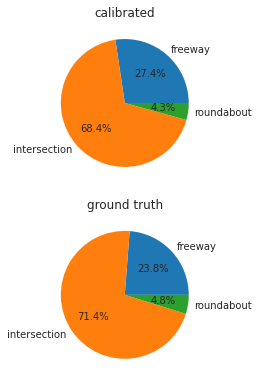

In [22]:
location_distribution = neg_caused_collision.groupby("location").sum()/importance_all
proportion = location_distribution["exp_importance"]
print(proportion)

plt.figure(figsize=(20, 10))
plt.subplot(3, 1, 1)
plt.pie(proportion, labels=proportion.index, autopct='%1.1f%%')
# plt.bar(proportion.index, values=proportion)
plt.title("calibrated")
plt.subplot(3, 1, 2)
true_dist = np.array([1525, 4581, 307]) / (1525 + 4581 + 307)
plt.pie(true_dist, labels=proportion.index, autopct='%1.1f%%')
# plt.bar(proportion.index, values=true_dist)
plt.title("ground truth")

In [23]:
def pie_chart_plot(df, mode, feat_name):
    mark = df["location"] == mode
    labels = df[mark][feat_name]
    values = df[mark]["importance_rate"]
    plt.pie(values, labels=labels, autopct='%1.1f%%')
    # plt.bar(labels, values)
    plt.title(f'{mode}')
    # plt.legend(labels)

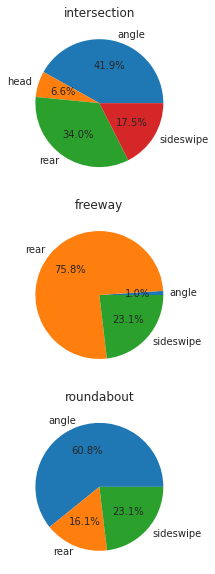

In [24]:
plt.figure(figsize=(30, 10))
plt.subplot(3, 1, 1)
pie_chart_plot(crash_type_dist, "intersection", "collision")
plt.subplot(3, 1, 2)
pie_chart_plot(crash_type_dist, "freeway", "collision")
plt.subplot(3, 1, 3)
pie_chart_plot(crash_type_dist, "roundabout", "collision")
plt.savefig(f"{export_stat_dir}/pie_chart.png")

In [26]:
len(neg_caused_collision)

1902

#### Negligence reason

In [27]:
neg_reason_crash_dist = crash_distribution(neg_caused_collision, "neg_reason")
neg_reason_crash_dist

,location,neg_reason,count,exp_importance,collision_rate,importance_rate
0,freeway,Lead,36,0.468647,0.001750,2.278637e-05
1,freeway,LeftFoll,143,0.072980,0.006953,3.548382e-06
2,freeway,RightFoll,140,0.076431,0.006807,3.716187e-06
3,intersection,Lead,1016,0.536518,0.049400,2.608635e-05
4,intersection,LeftFoll,207,0.315580,0.010065,1.534399e-05
5,intersection,RightFoll,68,0.098635,0.003306,4.795800e-06
6,intersection,TFL,116,0.594175,0.005640,2.888973e-05
7,roundabout,Lead,36,0.018865,0.001750,9.172509e-07
8,roundabout,LeftFoll,66,0.035514,0.003209,1.726725e-06
9,roundabout,RightFoll,74,0.042012,0.003598,2.042695e-06


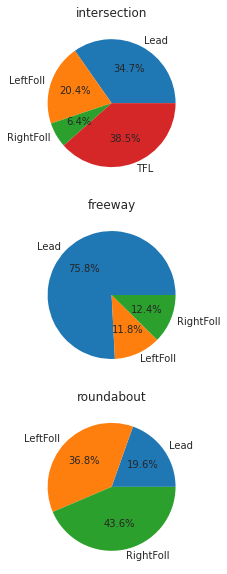

In [28]:
plt.figure(figsize=(30, 10))
plt.subplot(3, 1, 1)
pie_chart_plot(neg_reason_crash_dist, "intersection", "neg_reason")
plt.subplot(3, 1, 2)
pie_chart_plot(neg_reason_crash_dist, "freeway", "neg_reason")
plt.subplot(3, 1, 3)
pie_chart_plot(neg_reason_crash_dist, "roundabout", "neg_reason")
plt.savefig(f"{export_stat_dir}/neg_reason_pie_chart.png")

#### BV 22 Negligence Caused

In [29]:
is_veh_1_bv_22 = np.array(list(map(lambda x: x.startswith("BV_22"), neg_caused_collision["crash_veh_1"])))
is_veh_2_bv_22 = np.array(list(map(lambda x: x.startswith("BV_22"), neg_caused_collision["crash_veh_2"])))
has_bv_22 = is_veh_1_bv_22 | is_veh_2_bv_22
bv_22_neg_caused_collision = neg_caused_collision[has_bv_22]



bv_22_crash_type_dist = crash_distribution(bv_22_neg_caused_collision, "collision")
bv_22_crash_type_dist

,location,collision,count,exp_importance,collision_rate,importance_rate
0,freeway,angle,5,0.003089,0.000243,1.501802e-07
1,freeway,rear,5,0.066265,0.000243,3.221887e-06
2,freeway,sideswipe,19,0.007650,0.000924,3.719513e-07
3,intersection,angle,11,0.019083,0.000535,9.278285e-07
4,intersection,rear,73,0.039488,0.003549,1.919970e-06
5,intersection,sideswipe,37,0.056246,0.001799,2.734768e-06
6,roundabout,angle,16,0.009034,0.000778,4.392508e-07
7,roundabout,rear,6,0.002919,0.000292,1.419368e-07
8,roundabout,sideswipe,2,0.001327,0.000097,6.452588e-08


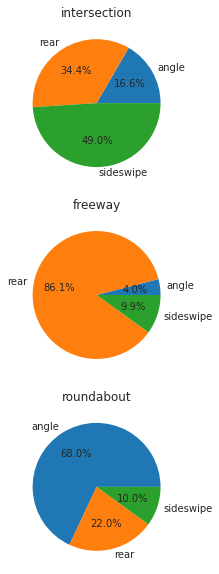

In [30]:
plt.figure(figsize=(30, 10))
plt.subplot(3, 1, 1)
pie_chart_plot(bv_22_crash_type_dist, "intersection", "collision")
plt.subplot(3, 1, 2)
pie_chart_plot(bv_22_crash_type_dist, "freeway", "collision")
plt.subplot(3, 1, 3)
pie_chart_plot(bv_22_crash_type_dist, "roundabout", "collision")
plt.savefig(f"{export_stat_dir}/bv_22_pie_chart.png")

##### EG happened collision intersection&angle

In [31]:
eg_collision = list(neg_caused_collision["lane_id"])
eg_collision_angle_df = neg_caused_collision[((neg_caused_collision["collision"] == "angle") | (neg_caused_collision["collision"] == "sideswipe")) & (neg_caused_collision["location"] == "freeway")]
# print(neg_caused_collision["relative_heading"])
# print(len(neg_caused_collision["relative_heading"]))

heading_float_list = [float(heading) for heading in eg_collision_angle_df["relative_heading"] if heading != 'None']
heading_float_list = np.array(heading_float_list)
print(len(heading_float_list))

284


In [32]:
eg_collision_angle_df = eg_collision_angle_df.sort_values(by="relative_heading")
eg_collision_angle_df["exp_cum"] = eg_collision_angle_df["exp_importance"].cumsum() / eg_collision_angle_df["exp_importance"].sum()
eg_collision_angle_df[eg_collision_angle_df["exp_cum"] < 28.08/(28.08+2.52)]

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,...,lane_id,collision_type,location_type,relative_heading,distance,collision_severity,exp_importance,location,collision,exp_cum
4497,ITE_autoware_universe_map_recalibrate_v4_290_24,1152.1,909,300,BV_17.57,BV_17.58,3.233618,1000,BV_17.57,0.6,...,EG_1_1_1_0,sideswipe,freeway_2,16.600091794162438,-1.125556,2.871257,0.000584,freeway,sideswipe,0.003908
18549,ITE_autoware_universe_map_recalibrate_v4_0_30,1399.3,1190,300,BV_21.77,BV_22.15,3.241062,695,BV_21.77,0.6,...,EG_1_3_1_0,sideswipe,freeway_1,16.729559264261525,-1.188943,3.057830,0.000574,freeway,sideswipe,0.007750
12147,ITE_autoware_universe_map_recalibrate_v4_280_5,1153.5,916,300,BV_21.57,BV_14.9,3.264423,439,BV_21.57,0.6,...,EG_1_3_1_0,sideswipe,freeway_1,16.780710991053397,-0.385915,3.880434,0.000544,freeway,sideswipe,0.011391
2591,ITE_autoware_universe_map_recalibrate_v4_100_3,1094.4,987,300,BV_17.65,BV_17.64,3.258253,509,BV_17.65,0.6,...,EG_1_1_1_0,sideswipe,freeway_2,16.91467591554442,-0.068514,2.963541,0.000552,freeway,sideswipe,0.015084
18040,ITE_autoware_universe_map_recalibrate_v4_444_20,1218.1,932,300,BV_8.60,BV_17.53,3.234148,768,BV_8.60,0.6,...,EG_1_3_1_1,sideswipe,freeway_1,16.97215131325595,-0.537373,3.412817,0.000583,freeway,sideswipe,0.018987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8025,ITE_autoware_universe_map_recalibrate_v4_127_7,1202.1,981,300,BV_21.56,BV_17.54,3.162454,1018,BV_21.56,0.6,...,EG_1_3_1_0,sideswipe,freeway_1,19.24194410163625,-1.047637,2.032401,0.000688,freeway,sideswipe,0.901374
3115,ITE_autoware_universe_map_recalibrate_v4_53_23,1250.6,1197,300,BV_8.72,BV_17.84,3.272258,132,BV_8.72,0.6,...,EG_1_3_1_1,sideswipe,freeway_1,19.326373928746534,-1.258836,1.963536,0.000534,freeway,sideswipe,0.904950
749,ITE_autoware_universe_map_recalibrate_v4_170_23,1180.1,907,300,BV_21.60,BV_8.66,3.211523,490,BV_21.60,0.6,...,EG_1_3_1_0,sideswipe,freeway_1,19.328861868943477,-0.537934,2.033890,0.000614,freeway,sideswipe,0.909062
7518,ITE_autoware_universe_map_recalibrate_v4_411_34,974.7,924,300,BV_17.53,BV_8.54,3.279671,132,BV_17.53,0.6,...,EG_1_3_1_0,sideswipe,freeway_1,19.3357894410844,-0.207761,2.022663,0.000525,freeway,sideswipe,0.912577


0.045774647887323945


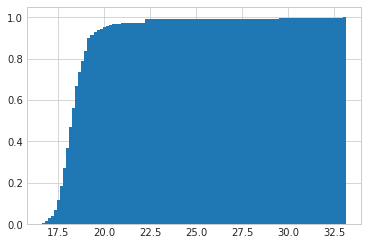

In [33]:
# # draw the histogram of the relative_heading of the collision in each location in neg_caused_collision
# grouped_neg_collision = neg_caused_collision["relative_heading"].groupby(neg_caused_collision["location"])
# for name, group_data in grouped_neg_collision:
#     plt.figure()
#     plt.hist(group_data, bins=50)
#     # plt.title(f"Collision Relative Heading Distribution in {name}")
# heading_flaot_list = np.clip(heading_flaot_list, 0, 30)
plt.figure()
plt.hist(heading_float_list, bins=100, density=True, cumulative=True)

print(np.sum(heading_float_list>20)/len(heading_float_list))

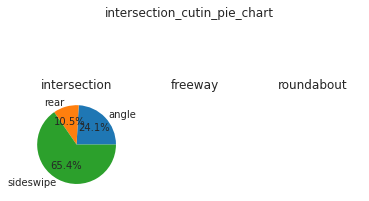

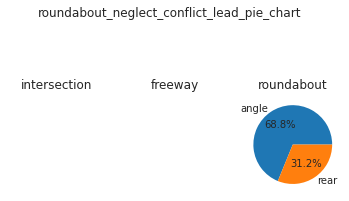

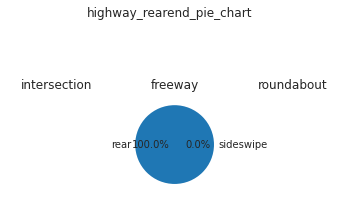

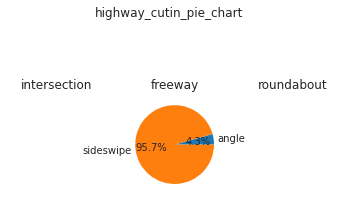

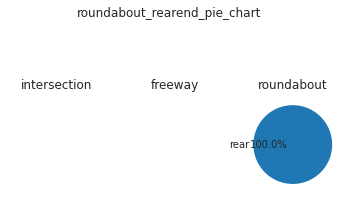

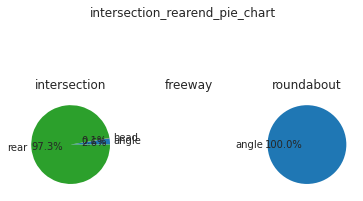

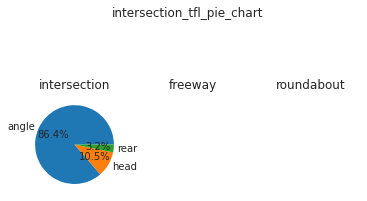

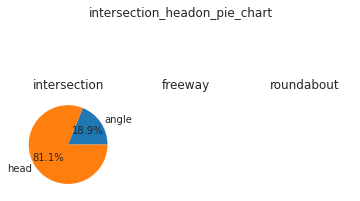

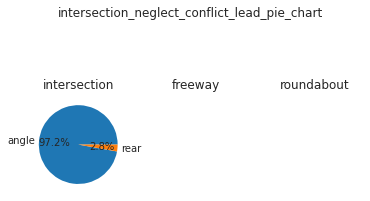

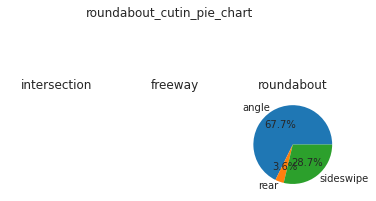

In [34]:
neg_uniq_infos = neg_caused_collision["neg_info"].unique()

neg_info_crash_dist = {}
for info in neg_uniq_infos:
    df = neg_caused_collision[neg_caused_collision["neg_info"] == info].copy()
    
    crash_type_dist = crash_distribution(df, "collision")
    neg_info_crash_dist[info] = crash_type_dist
    plt.figure()
    plt.subplot(1, 3, 1)
    pie_chart_plot(crash_type_dist, "intersection", "collision")
    plt.subplot(1, 3, 2)
    pie_chart_plot(crash_type_dist, "freeway", "collision")
    plt.subplot(1, 3, 3)
    pie_chart_plot(crash_type_dist, "roundabout", "collision")
    plt.suptitle(f"{info}_pie_chart")
    plt.savefig(f"{export_stat_dir}/{info}_pie_chart.png")

In [35]:
from IPython.display import display
for info, crash_dist in neg_info_crash_dist.items():
    print(info)
    display(crash_dist)

intersection_cutin


,location,collision,count,exp_importance,collision_rate,importance_rate
0,intersection,angle,70,0.099955,0.003404,0.000005
1,intersection,rear,29,0.043487,0.001410,0.000002
2,intersection,sideswipe,176,0.270773,0.008557,0.000013


roundabout_neglect_conflict_lead


,location,collision,count,exp_importance,collision_rate,importance_rate
0,roundabout,angle,7,0.004005,0.000340,1.947358e-07
1,roundabout,rear,4,0.001815,0.000194,8.824242e-08


highway_rearend


,location,collision,count,exp_importance,collision_rate,importance_rate
0,freeway,rear,35,0.468642,0.001702,2.278611e-05
1,freeway,sideswipe,1,0.000005,0.000049,2.624617e-10


highway_cutin


,location,collision,count,exp_importance,collision_rate,importance_rate
0,freeway,angle,13,0.006439,0.000632,3.130673e-07
1,freeway,sideswipe,270,0.142972,0.013128,6.951502e-06


roundabout_rearend


,location,collision,count,exp_importance,collision_rate,importance_rate
0,roundabout,rear,21,0.010957,0.001021,5.327268e-07


intersection_rearend


,location,collision,count,exp_importance,collision_rate,importance_rate
0,intersection,angle,22,0.012353,0.001070,6.006098e-07
1,intersection,head,1,0.000505,0.000049,2.455505e-08
2,intersection,rear,875,0.462692,0.042544,2.249682e-05
3,roundabout,angle,4,0.002088,0.000194,1.015459e-07


intersection_tfl


,location,collision,count,exp_importance,collision_rate,importance_rate
0,intersection,angle,90,0.507562,0.004376,2.467846e-05
1,intersection,head,10,0.061498,0.000486,2.990138e-06
2,intersection,rear,4,0.018678,0.000194,9.081488e-07


intersection_headon


,location,collision,count,exp_importance,collision_rate,importance_rate
0,intersection,angle,18,0.009186,0.000875,4.466344e-07
1,intersection,head,77,0.039368,0.003744,1.914158e-06


intersection_neglect_conflict_lead


,location,collision,count,exp_importance,collision_rate,importance_rate
0,intersection,angle,34,0.018321,0.001653,8.908117e-07
1,intersection,rear,1,0.000529,0.000049,2.574048e-08


roundabout_cutin


,location,collision,count,exp_importance,collision_rate,importance_rate
0,roundabout,angle,94,0.052523,0.004570,2.553747e-06
1,roundabout,rear,6,0.002758,0.000292,1.341069e-07
2,roundabout,sideswipe,40,0.022245,0.001945,1.081566e-06


In [36]:
! pip install gurobipy
col_names = ["ia", "ih", "ir", "is", "ra", "rr", "rs", "fr", "fs", "fa"]

row_names = [
    "intersection_cutin", 
    "intersection_neglect_conflict_lead", 
    "intersection_rearend", 
    "intersection_tfl",
    "intersection_headon",
    "roundabout_cutin",
    "roundabout_neglect_conflict_lead",
    "roundabout_rearend",
    "highway_cutin",
    "highway_rearend"
]

translate_col = {col: i for i, col in enumerate(col_names)}
translate_row = {row: i for i, row in enumerate(row_names)}

A = np.zeros((len(translate_row), len(translate_col))).astype(int)
for row_mark in neg_info_crash_dist.keys():
    df = neg_info_crash_dist[row_mark]
    important_values = df["importance_rate"]
    col_marks = np.array(list(map(lambda x: x[1][0][0]+x[1][1][0], df.iterrows())))
    for col_mark, v in zip(col_marks, important_values):
        if col_mark in translate_col:
            A[translate_row[row_mark], translate_col[col_mark]] = v * 1e9
A = A.T

Defaulting to user installation because normal site-packages is not writeable


In [37]:
A[:4, 5:] = 0
A[4:, :5] = 0
A[:7, 8:] = 0
A[7:, :8] = 0

In [38]:
A

array([[ 4859,   890,   600, 24678,   446,     0,     0,     0,     0,
            0],
       [    0,     0,    24,  2990,  1914,     0,     0,     0,     0,
            0],
       [ 2114,    25, 22496,   908,     0,     0,     0,     0,     0,
            0],
       [13165,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [    0,     0,     0,     0,     0,  2553,   194,     0,     0,
            0],
       [    0,     0,     0,     0,     0,   134,    88,   532,     0,
            0],
       [    0,     0,     0,     0,     0,  1081,     0,     0,     0,
            0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
        22786],
       [    0,     0,     0,     0,     0,     0,     0,     0,  6951,
            0],
       [    0,     0,     0,     0,     0,     0,     0,     0,   313,
            0]])

#### Calibration

In [39]:
import itertools
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

class StopExecution(Exception):
    def _render_traceback_(self):
        pass

# basic parameters
n = A.shape[1]
m = A.shape[0]
b = np.array([1839, 285, 1648, 808, 169, 53, 85, 1058, 428, 38])
all_miles = all_routes / mile_to_m
b = b / b.sum() * all_miles / num_experiments * 3e3

# Gurobi model
model = gp.Model()
model.reset()

# variable
x = model.addVars(range(n), lb=0.1)
t = model.addVars(range(m), lb=0)
upper = model.addVar(lb=1)
lower = model.addVar(lb=0)

# optimization goal
model.setObjective(sum(t[i] for i in range(m)) + 20 * upper + 200 * (1-lower), GRB.MINIMIZE)

# constraints
model.addConstrs(sum(x[j] * A[i, j] for j in range(n)) - b[i] <= t[i] for i in range(m))
model.addConstrs(sum(x[j] * A[i, j] for j in range(n)) - b[i] >= -t[i] for i in range(m))
model.addConstrs(x[i] <= upper for i in range(n))
model.addConstrs(x[i] >= lower for i in range(n))
model.update()

# solve the model
model.optimize()
if model.status != GRB.Status.OPTIMAL:
    print("***** Gurobi solve status:", model.status)
    print("***** This is a problem. Model does not have an optimal solution")
    raise StopExecution
print(" ")
print("***** Solution:")
# x_solved = np.array([x[i].X for i in range(n)]).reshape(-1, 1)
# t_solved = np.array([t[i].X for i in range(m)]).reshape(-1, 1)
x_solved = [x[i].X for i in range(n)]
t_solved = [t[i].X for i in range(m)]
x_mark_solved = list(zip(translate_row, x_solved))
t_mark_solved = list(zip(translate_col, t_solved))
print("x =",  *x_mark_solved, sep="\n")
print("t =",  *t_mark_solved, sep="\n")
print("x upper bound = ", upper.X)
print("x upper bound = ", lower.X)
print("b =", b)

Restricted license - for non-production use only - expires 2024-10-28
Discarded solution information
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: Intel(R) Xeon(R) Gold 6154 CPU @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 36 physical cores, 36 logical processors, using up to 32 threads

Optimize a model with 40 rows, 22 columns and 104 nonzeros
Model fingerprint: 0x884ef257
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [1e+00, 2e+02]
  Bounds range     [1e-01, 1e+00]
  RHS range        [6e+02, 3e+04]
Presolve time: 0.21s
Presolved: 40 rows, 22 columns, 104 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0000000e+32   1.000000e+31   2.000000e+02      0s
      19    6.6370207e+02   0.000000e+00   0.000000e+00      0s

Solved in 19 iterations and 0.29 seconds (0.00 work units)
Optimal objective  6.637020704e+02
 
***** Solution:
x =
('intersection_cutin', 1.008502608456047)


### Quick check

In [40]:
quick_check_exp = no_neg_realated_collision.groupby("lane_id").agg({
    "name": ["nunique", "first"],
    # "veh_1_route": set,
    # "veh_2_route": set,
    # "experiment": "first"
})
# quick_check_exp["veh_route"] = quick_check_exp[["veh_1_route", "veh_2_route"]].apply(lambda x: set(x[0]) | set(x[1]), axis=1)
quick_check_exp.sort_values(by=("name", "nunique"), ascending=False)

name                                                 
               nunique                                            first
lane_id                                                                
:NODE_18_10_0       70   ITE_autoware_universe_map_recalibrate_v4_86_23
:nd_34_1_6_0_0      20  ITE_autoware_universe_map_recalibrate_v4_296_32
:NODE_11_15_0       12   ITE_autoware_universe_map_recalibrate_v4_63_19
:nd_34_1_6_1_0      11  ITE_autoware_universe_map_recalibrate_v4_391_32
EG_18_12_171_1       9   ITE_autoware_universe_map_recalibrate_v4_408_4
:NODE_11_16_0        5  ITE_autoware_universe_map_recalibrate_v4_461_21
EG_16_45_1_1         5  ITE_autoware_universe_map_recalibrate_v4_178_39
:NODE_18_17_0        4  ITE_autoware_universe_map_recalibrate_v4_188_36
:NODE_18_8_0         2   ITE_autoware_universe_map_recalibrate_v4_23_30
EG_18_12_171_0       2  ITE_autoware_universe_map_recalibrate_v4_305_33
gneE8_0              2   ITE_autoware_universe_map_recalibrate_v4_73_19
:NODE_18_1_0         1   ITE_autoware_universe_map_recalibrate_v4_52_15
:NODE_24_5_0         1  ITE_autoware_universe_map_recalibrate_v4_250_13
EG_34_1_16_0         1  ITE_autoware_universe_map_recalibrate_v4_151_11

0.03214867657825938 8.529309707331033e-14


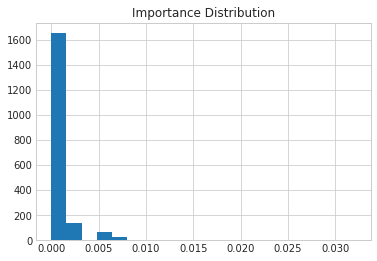

In [41]:
plt.hist(collide_importance_weight, bins=20)
plt.title("Importance Distribution")
plt.savefig(f'{export_stat_dir}/importance.png', dpi=300)
print(collide_importance_weight.max(), collide_importance_weight.min())

#### Export the checklist

In [42]:
# simple checklist
quick_check_list_path = f"{export_stat_dir}/quick_check_list.txt"
neg_caused_check_list_path = f"{export_stat_dir}/neg_caused_check_list.txt"
non_neg_check_list_path = f"{export_stat_dir}/non_neg_check_list.txt"

with open(quick_check_list_path, "w") as f:
    print(*set(quick_check_exp[("name", "first")].values), sep="\n", file=f)
with open(neg_caused_check_list_path, "w") as f:
    print(*set(neg_caused_collision["name"].values), sep="\n", file=f)
with open(non_neg_check_list_path, "w") as f:
    print(*set(no_neg_realated_collision["name"].values), sep="\n", file=f)

In [43]:
# ! pip install shapely

In [44]:
exp_stats_info

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
0,ITE_autoware_universe_map_recalibrate_v4_118_1,1257.0,957,300,NaN,NaN,-0.074820,666,NaN,-1.0,NaN,NaN,53816.192710,1047.978212,NaN,NaN,NaN,None,-10.000000,NaN
1,ITE_autoware_universe_map_recalibrate_v4_118_2,1397.0,1097,300,NaN,NaN,-0.116591,699,NaN,-1.0,NaN,NaN,57202.698658,843.248076,NaN,NaN,NaN,None,-10.000000,NaN
2,ITE_autoware_universe_map_recalibrate_v4_118_3,1310.6,1179,300,BV_2.31,BV_7.11,2.777301,710,BV_2.31,0.6,LeftFoll,intersection_cutin,31190.661110,140.829624,EG_8_23_12_1,angle,intersection,20.583022226154412,-1.116604,0.960536
3,ITE_autoware_universe_map_recalibrate_v4_118_4,1466.0,1166,300,NaN,NaN,2.176504,709,NaN,-1.0,NaN,NaN,51465.757701,1559.678246,NaN,NaN,NaN,None,-10.000000,NaN
4,ITE_autoware_universe_map_recalibrate_v4_118_5,1341.0,1041,300,NaN,NaN,-0.174743,1065,NaN,-1.0,NaN,NaN,60747.694151,3946.686037,NaN,NaN,NaN,None,-10.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20562,ITE_autoware_universe_map_recalibrate_v4_293_34,1450.0,1150,300,NaN,NaN,-0.155910,1487,NaN,-1.0,NaN,NaN,66276.458726,3803.659147,NaN,NaN,NaN,None,-10.000000,NaN
20563,ITE_autoware_universe_map_recalibrate_v4_293_35,1214.0,914,300,NaN,NaN,-0.084115,1001,NaN,-1.0,NaN,NaN,57122.860494,751.356685,NaN,NaN,NaN,None,-10.000000,NaN
20564,ITE_autoware_universe_map_recalibrate_v4_293_36,1460.0,1160,300,NaN,NaN,-0.085742,1128,NaN,-1.0,NaN,NaN,63446.805401,2043.834275,NaN,NaN,NaN,None,-10.000000,NaN
20565,ITE_autoware_universe_map_recalibrate_v4_293_37,1452.0,1152,300,NaN,NaN,-0.227453,1272,NaN,-1.0,NaN,NaN,68419.067125,7240.613418,NaN,NaN,NaN,None,-10.000000,NaN


### Generate videos in the check list

In [45]:
exp_stats_info["location"] = list(map(get_type_func, exp_stats_info["location_type"]))
exp_stats_info["collision"] = list(map(get_type_func, exp_stats_info["collision_type"]))

In [46]:
def get_location_collision_type(exp_id, exp_stats_info):
    mark = exp_stats_info["name"] == exp_id
    location_type = exp_stats_info[mark]["location"].values[0]
    collision_type = exp_stats_info[mark]["collision"].values[0]
    return location_type, collision_type

def export_videos(export_path, file_name, map_location="."):
    if not os.path.exists(export_path):
        os.system(f"mkdir -p {export_path}")
        os.system(f"chmod 755 {export_path}")
    with open(file_name) as f:
        for line in tqdm(f.readlines()): 
            exp_id = line.strip()
            path_name = os.path.join(experiment_record_repo, exp_id)
            if os.path.isdir(path_name):
                location_type, collision_type = get_location_collision_type(exp_id, exp_stats_info)
                if location_type == "None" or collision_type == "None":
                    visualizer(map_location, experiment_record_repo, exp_id, os.path.join(export_path, "None"))
                else:
                    visualizer(map_location, experiment_record_repo, exp_id, os.path.join(export_path, f"{location_type}/{collision_type}"))

In [47]:
# 生成三个文件夹: simple(typical) non-negligence-caused negligence-caused 
export_path = f"{exp_repo}/{mode}/{user}/videos"
file_name = f"{export_stat_dir}/check_list.txt"

# quick check
# export_videos(f"{export_path}/quick_check", "check.txt")

export_videos(f"{export_path}/non_neg_check", non_neg_check_list_path)
# export_videos(f"{export_path}/neg_caused_check", neg_caused_check_list_path)

  0%|          | 0/145 [00:01<?, ?it/s]

/gpfs/accounts/henryliu_root/henryliu98/shared_data/safetest-nade/ITE_autoware_universe_map_recalibrate_v4/raw_data/final_state/ITE_autoware_universe_map_recalibrate_v4_52_final_state.json


FileNotFoundError: [Errno 2] No such file or directory: './maps/Mcity/mcity.net.xml'

### See README-viz.md for visualization

In [ ]:
exp_stats_info[(exp_stats_info["location"] == "roundabout") & (exp_stats_info["lane_id"] == ":NODE_21_0_0") & (exp_stats_info["neg_info"] == "roundabout_neglect_conflict_lead")]["name"].values

In [ ]:
exp_stats_info[(exp_stats_info["location"] == "roundabout")]["lane_id"].unique()